In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [12]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [14]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [17]:
#inspecting the table "measurement" in db with inspector module
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
#inspecting the table "station" in db with inspector module
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

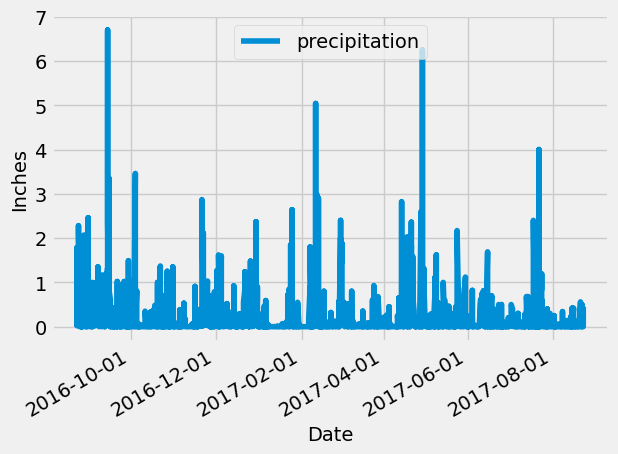

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = recent_date[0]

# Calculate the date one year from the last date in data set.
earliest_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = [Measurement.date,
func.round(Measurement.prcp, 2)]

prcp_data = session.query(*data).\
filter(func.strftime(Measurement.date) >= earliest_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names. Dataframe sorted by date
df = pd.DataFrame(prcp_data, columns=['date','precipitation']).sort_values(by=['date'])
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index).date
df.dropna(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
#REFERENCE 1: https://dataplotplus.com/change-datetime-tick-label-frequency-matplotlib-plots/
ax = df.plot()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation = 45)
ax.legend(loc="upper center")
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()





In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.id)).all()

[(9,)]

In [24]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
data = [Measurement.station ,
func.count(Measurement.station)]
session.query(*data).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station= session.query(*data).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
active_station= active_station[0]
active_station

temp_data = [func.min(Measurement.tobs),
func.max(Measurement.tobs),
func.avg(Measurement.tobs)]
session.query(*temp_data).filter(Measurement.station == active_station).all()

[(54.0, 85.0, 71.66378066378067)]

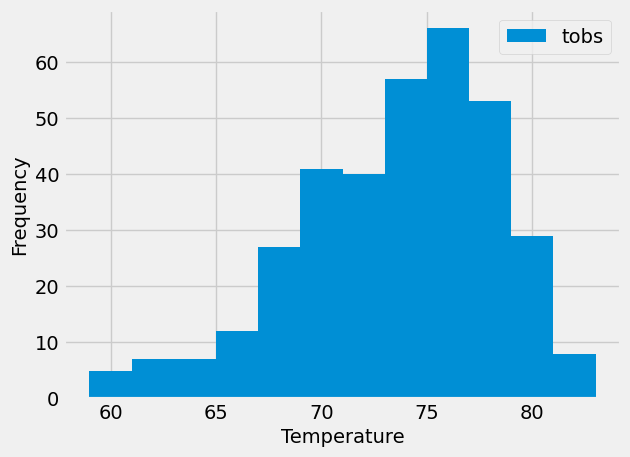

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.station,Measurement.date, Measurement.tobs).\
filter((func.strftime(Measurement.date) >= earliest_date),(Measurement.station == active_station)).all()

#Create and save the query as Pd frame
df = pd.DataFrame(temperature_data, columns=['station_name','date', 'tobs'])
df.dropna(inplace=True)

#Plot the histogram
df.plot.hist(column=['tobs'], bins=12)
plt.xlabel('Temperature')
plt.show()

# Close Session

In [32]:
# Close Session
session.close()